# Model fits using `emcee` for parameter uncertainty estimates

Note that `emcee` is not used for the model fits themselves, which we do first using `lmfit` with another method (e.g., Levenberg–Marquardt or Nelder–Mead).

## Load libraries and define helper functions

In [94]:
import cmasher as cmr
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
import lmfit
import json
import astropy.units as u
import bfunc
import pandas as pd
import corner

In [2]:
sns.set_color_codes()
sns.set_context("talk")

In [3]:
def values2arrays(d):
    for k in d.keys():
        if type(d[k]) == list:
            d[k] = np.array(d[k])
    return d

## Load example dataset and clean it up to be ready for fitting

Javier's workflow already does this in the `SFxxx.ipynb` notebooks and saves the cleaned up data in `SFresults/*.pkl`. But I am using my own Orion structure function from a JSON file, so I need to do the clean-up here.

In [4]:
with open("orion-strucfunc-ha.json") as f:
    sf = values2arrays(json.load(f))
mask = sf["N pairs"] > 0

# Translation from pixels to parsecs
Distance_pc = 410
pix_scale_arcsec = 0.534
pc_per_arcsec = (Distance_pc * (u.au / u.pc)).cgs.value
pix_scale_pc = pc_per_arcsec * pix_scale_arcsec

# Finite box size for Orion KPNO data
box_size = np.sqrt(356 * 512) * pix_scale_pc

# We want ro fit B(r)
r = 10**sf["log10 r"][mask]
r *= pix_scale_pc
B = sf["Unweighted B(r)"][mask]


## Set the parameters for the fit

We use `lmfit` to infer the parameter names from the model:

In [188]:
model = lmfit.Model(bfunc.bfunc04s)
model.param_names

['r0', 'sig2', 'm', 's0', 'noise', 'box_size']

We want `box_size` to be fixed, but the other parameters can vary.  By default, `lmfit` uses `emcee` with uniform priors within the allowed range of each parameter. I think that this means that we will need to give an explicit range for each.

In [189]:
# Correlation length between 1/10 and 2 x box_size
model.set_param_hint("r0", value=0.1 * box_size, min=0.01 * box_size, max=2 * box_size)

# sig2 between 1/4 and 2 x max value of B(r)
model.set_param_hint("sig2", value=0.5 * B.max(), min=0.25 * B.max(), max=2 * B.max())

# m between 1/2 and 5/3
model.set_param_hint("m", value=1.0, min=0.5, max=1.667)

# Seeing RMS between 0.1 and 1.5 arcsec
model.set_param_hint("s0", value=0.5 * pc_per_arcsec, min=0.1 * pc_per_arcsec, max=1.5 * pc_per_arcsec)

# Noise cannot be much larger than smallest B(r)
model.set_param_hint("noise", value=0.5 * B.min(), min=0.0, max=3 * B.min())

# box_size is fixed
model.set_param_hint("box_size", value=box_size, vary=False)

In [190]:
pd.DataFrame(model.param_hints)

,r0,sig2,m,s0,noise,box_size
value,0.045317,11.801099,1.000,0.000994,0.015019,0.453169
min,0.004532,5.900549,0.500,0.000199,0.000000,NaN
max,0.906338,47.204394,1.667,0.002982,0.090115,NaN
vary,NaN,NaN,NaN,NaN,NaN,False


## Set the weights for the fit

For the time being, carry on using the constant relative uncertainty. 

_But we really ought to implement the fourth order differences in the strucfunc calculation so we can calculate the errors properly_

In [191]:
relative_uncertainty = 0.02
weights = 1.0 / (relative_uncertainty * B)
large_scale = r > 0.5 * box_size
weights[large_scale] /= 8.0
weights[:3] /= 3.0

We increase the error bars for the first 3 points, since they have smaller number of pairs.  We exclude separations larger than half the box size from the fit.  I think this makes more sense than just increasing the errors there.

## Perform the fit and look at results

In [192]:
to_fit = ~large_scale
result = model.fit(B[to_fit], weights=weights[to_fit], r=r[to_fit])

Look at the results. It seems that `lmfit` will now use a rich representation of the result to display in a notebook. 

In [193]:
result

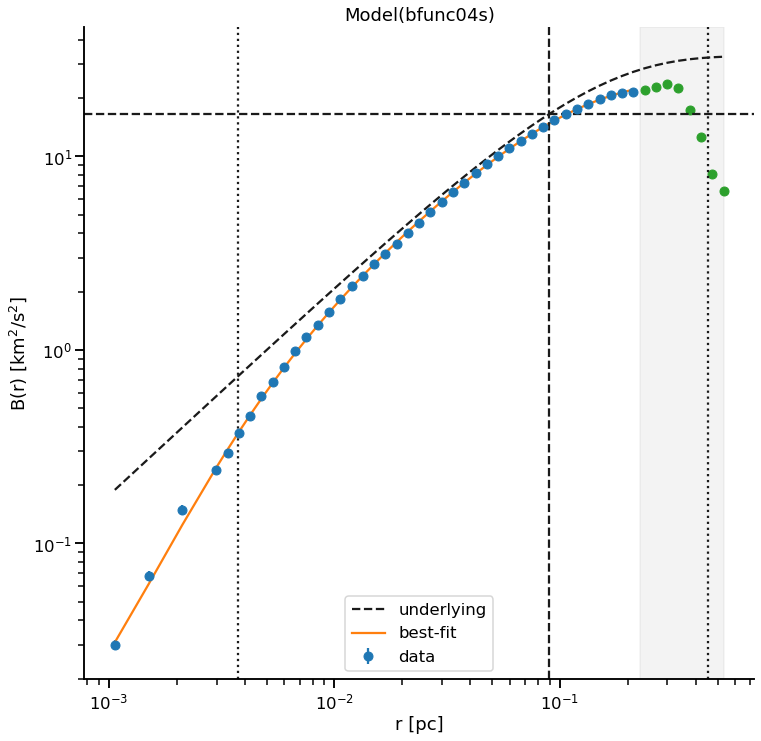

In [194]:
fig, ax = plt.subplots(figsize=(12, 12))

# Plot the underlying model without instrumental effects
Bu = bfunc.bfunc00s(r, result.params["r0"].value, result.params["sig2"].value, result.params["m"].value)
ax.plot(r, Bu, color="k", linestyle="dashed", label="underlying")

# Plot the fit results
result.plot_fit(ax=ax)

# Add in the points not included in fit
ax.plot(r[large_scale], B[large_scale], "o")

# Dotted lines for 2 x rms seeing and for box size
ax.axvline(2 * result.params["s0"].value, color="k", linestyle="dotted")
ax.axvline(result.params["box_size"].value, color="k", linestyle="dotted")

# Dashed lines for best-fit r0 and sig2
ax.axvline(result.params["r0"].value, color="k", linestyle="dashed")
ax.axhline(result.params["sig2"].value, color="k", linestyle="dashed")

# Gray box to indicate the large scale values that are excluded from the fit
ax.axvspan(result.params["box_size"].value / 2, r[-1], color="k", alpha=0.05, zorder=-1)

ax.set(
    xscale = "log",
    yscale = "log",
    xlabel = "r [pc]",
    ylabel = r"B(r) [km$^{2}$/s$^{2}$]",
)
sns.despine();


## Now try out emcee

The procedure is copied from [this example in the lmfit docs](https://lmfit.github.io/lmfit-py/examples/example_emcee_Model_interface.html). 

In [196]:
emcee_kws = dict(steps=15000, burn=1000, thin=50, is_weighted=True,
                 progress=False)
emcee_params = result.params.copy()
# emcee_params.add('__lnsigma', value=np.log(0.1), min=np.log(0.001), max=np.log(2.0))

The extra parameter `__lnsigma` is a scaling factor for the errors.  

In [197]:
result_emcee = model.fit(
    data=B[to_fit], r=r[to_fit], weights=weights[to_fit], params=emcee_params, method='emcee',
    nan_policy='omit', fit_kws=emcee_kws,
)

This takes about 2 minutes to run. 

In [198]:
result_emcee

Text(0, 0.5, 'acceptance fraction')

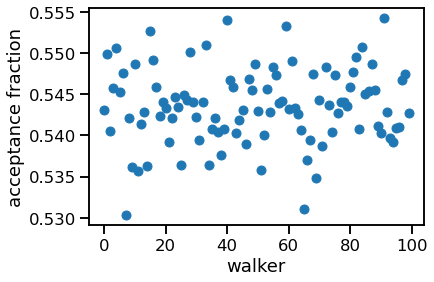

In [199]:
plt.plot(result_emcee.acceptance_fraction, 'o')
plt.xlabel('walker')
plt.ylabel('acceptance fraction')

In [204]:
if hasattr(result_emcee, "acor"):
    print("Autocorrelation time for the parameters:")
    print("----------------------------------------")
    for i, p in enumerate(result_emcee.params):
        try:
            print(f'{p} = {result_emcee.acor[i]:.3f}')
        except IndexError:
            pass

Autocorrelation time for the parameters:
----------------------------------------
r0 = 60.848
sig2 = 60.746
m = 59.016
s0 = 59.204
noise = 56.201


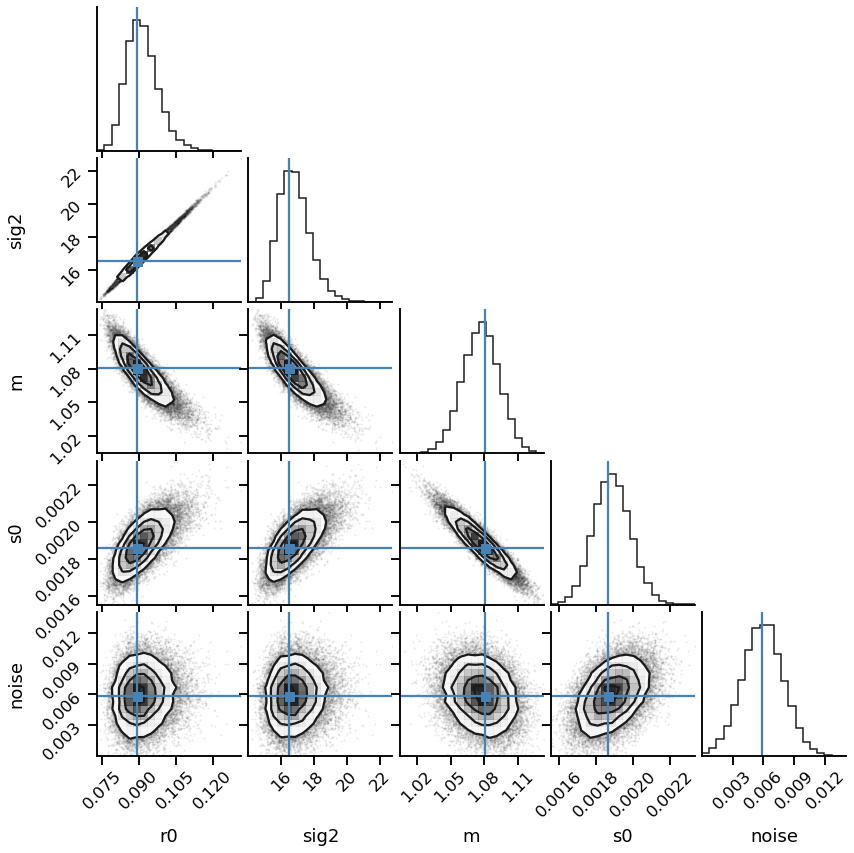

In [205]:
# We need to remove the frozen parameters from the list before passing it as the truths argument
truths = [_.value for _ in emcee_params.values() if _.vary]

emcee_corner = corner.corner(
    result_emcee.flatchain, 
    labels=result_emcee.var_names,
    truths=truths,
    labelpad=0.2,
)
sns.despine()

This seems to work pretty well. 

In [206]:
result_emcee.flatchain.iloc[999].r0

0.08605023587318793

In [207]:
result_emcee.params.valuesdict()

OrderedDict([('r0', 0.09087041619699227),
             ('sig2', 16.74624762185967),
             ('m', 1.077249164903526),
             ('s0', 0.00188589823777837),
             ('noise', 0.005960037422171736),
             ('box_size', 0.4531687565469501)])

## Use the emcee chain to plot the range of possible models

In [225]:
span_kwds = dict(alpha=0.05, zorder=-1, linestyle="none", color="k")
def spread_span(ax, values, orient="h", pairs=[[16, 84], [5, 95]]):
    for pair in pairs:
        if orient=="h":
            ax.axhspan(*np.percentile(values, pair), **span_kwds)
        else:
            ax.axvspan(*np.percentile(values, pair), **span_kwds)

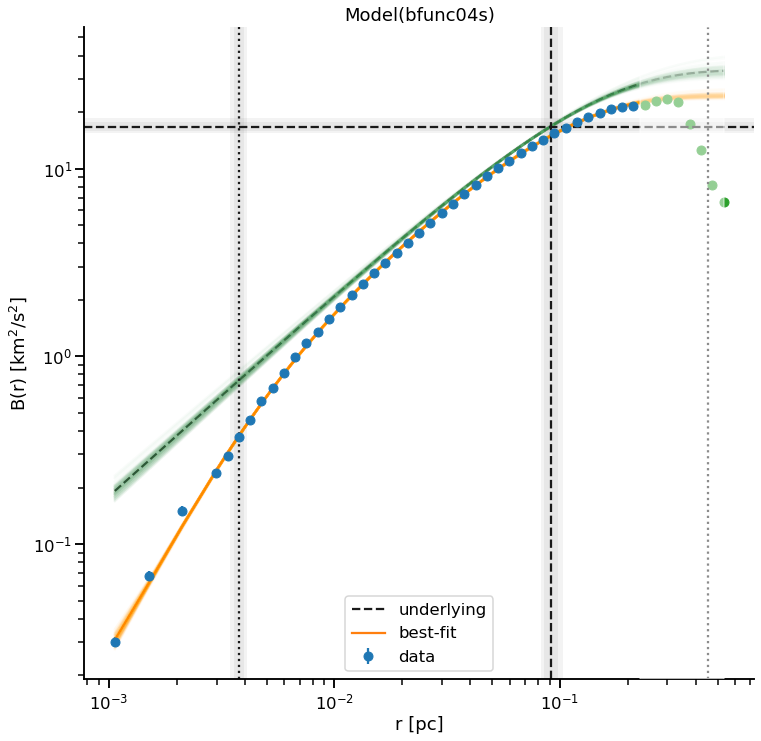

In [227]:
fig, ax = plt.subplots(figsize=(12, 12))

best = result_emcee.params.valuesdict()

# Plot the underlying model without instrumental effects
Bu = bfunc.bfunc00s(r, best["r0"], best["sig2"], best["m"])
ax.plot(r, Bu, color="k", linestyle="dashed", label="underlying")

# Plot the fit results
result_emcee.plot_fit(ax=ax)

# Plot a random sample of the emcee chain
inds = np.random.randint(len(result_emcee.flatchain), size=100)
for ind in inds:
    sample = result_emcee.flatchain.iloc[ind]
    Bsamp = bfunc.bfunc04s(r, sample.r0, sample.sig2, sample.m, sample.s0, sample.noise, box_size)
    ax.plot(r, Bsamp, alpha=0.03, color="orange")
    Busamp = bfunc.bfunc00s(r, sample.r0, sample.sig2, sample.m)
    ax.plot(r, Busamp, alpha=0.03, color="g")

# Add in the points not included in fit
ax.plot(r[large_scale], B[large_scale], "o")

# Dotted lines for 2 x rms seeing and for box size
ax.axvline(2 * best["s0"], color="k", linestyle="dotted")
spread_span(ax, 2 * result_emcee.flatchain.s0, orient="v")

ax.axvline(best["box_size"], color="k", linestyle="dotted")

# Dashed lines for best-fit r0 and sig2
ax.axvline(best["r0"], color="k", linestyle="dashed")
spread_span(ax, result_emcee.flatchain.r0, orient="v")

ax.axhline(best["sig2"], color="k", linestyle="dashed")
spread_span(ax, result_emcee.flatchain.sig2, orient="h")

# Gray box to indicate the large scale values that are excluded from the fit
ax.axvspan(best["box_size"] / 2, r[-1], color="w", alpha=0.5, zorder=100)

ax.set(
    xscale = "log",
    yscale = "log",
    xlabel = "r [pc]",
    ylabel = r"B(r) [km$^{2}$/s$^{2}$]",
)
sns.despine();


The orange lines are a sampling of the chains for the full model.  The green lines are the same for the "true" model. 

## Repeat for a distant source

In [246]:
import pickle
from pathlib import Path

jav_path = Path("../JavierGVastro/PhD.Paper/")

In [247]:
with open(jav_path / "SFresults" / "N604H.pkl", "rb") as f:
    sfdata = pickle.load(f)
with open(jav_path / "VFM" / "N604H.pkl", "rb") as f:
    vfdata = pickle.load(f)

sf = sfdata["SF"]
mask = sf["N pairs"] > 0

In [248]:
# Translation from pixels to parsecs
Distance_pc = 840_000
pix_scale_arcsec = vfdata["pix"]
pc_per_arcsec = (Distance_pc * (u.au / u.pc)).cgs.value
pix_scale_pc = pc_per_arcsec * pix_scale_arcsec

# Finite box size
box_size = 120 * pix_scale_pc

# We want ro fit B(r)
r = 10**sf["log10 r"][mask]
r *= pix_scale_pc
B = sf["Unweighted B(r)"][mask]

In [268]:
model = lmfit.Model(bfunc.bfunc04s)

# Correlation length between 1/10 and 2 x box_size
model.set_param_hint("r0", value=0.1 * box_size, min=0.01 * box_size, max=2 * box_size)

# sig2 between 1/4 and 2 x max value of B(r)
model.set_param_hint("sig2", value=0.5 * B.max(), min=0.25 * B.max(), max=2 * B.max())

# m between 0 and 2
model.set_param_hint("m", value=1.0, min=0.0, max=2.0)

# Seeing RMS between 0.1 and 1.5 arcsec
#model.set_param_hint("s0", value=0.5 * pc_per_arcsec, min=0.1 * pc_per_arcsec, max=1.5 * pc_per_arcsec)
model.set_param_hint("s0", value=1.0 * pc_per_arcsec / 2.35, vary=False)

# Noise cannot be much larger than smallest B(r)
model.set_param_hint("noise", value=0.5 * B.min(), min=0.0, max=3 * B.min())

# box_size is fixed
model.set_param_hint("box_size", value=box_size, vary=False)

relative_uncertainty = 0.15
weights = 1.0 / (relative_uncertainty * B)
large_scale = r > 0.5 * box_size
weights[large_scale] /= 3.0
#weights[:3] /= 3.0

to_fit = np.ones(B.shape, dtype=bool)
result = model.fit(B[to_fit], weights=weights[to_fit], r=r[to_fit])

In [269]:
result

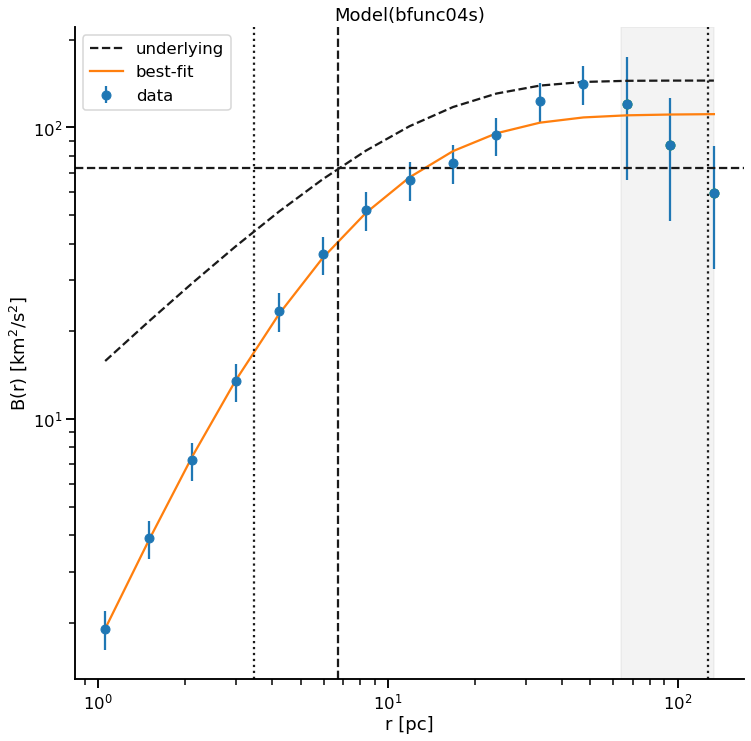

In [270]:
fig, ax = plt.subplots(figsize=(12, 12))

# Plot the underlying model without instrumental effects
Bu = bfunc.bfunc00s(r, result.params["r0"].value, result.params["sig2"].value, result.params["m"].value)
ax.plot(r, Bu, color="k", linestyle="dashed", label="underlying")

# Plot the fit results
result.plot_fit(ax=ax)

# Add in the points not included in fit
ax.plot(r[large_scale], B[large_scale], "o")

# Dotted lines for 2 x rms seeing and for box size
ax.axvline(2 * result.params["s0"].value, color="k", linestyle="dotted")
ax.axvline(result.params["box_size"].value, color="k", linestyle="dotted")

# Dashed lines for best-fit r0 and sig2
ax.axvline(result.params["r0"].value, color="k", linestyle="dashed")
ax.axhline(result.params["sig2"].value, color="k", linestyle="dashed")

# Gray box to indicate the large scale values that are excluded from the fit
ax.axvspan(result.params["box_size"].value / 2, r[-1], color="k", alpha=0.05, zorder=-1)

ax.set(
    xscale = "log",
    yscale = "log",
    xlabel = "r [pc]",
    ylabel = r"B(r) [km$^{2}$/s$^{2}$]",
)
sns.despine();


In [271]:
emcee_kws = dict(steps=5000, burn=500, thin=20, is_weighted=True,
                 progress=False)
emcee_params = result.params.copy()
result_emcee = model.fit(
    data=B[to_fit], r=r[to_fit], weights=weights[to_fit], params=emcee_params, method='emcee',
    nan_policy='omit', fit_kws=emcee_kws,
)
result_emcee

Text(0, 0.5, 'acceptance fraction')

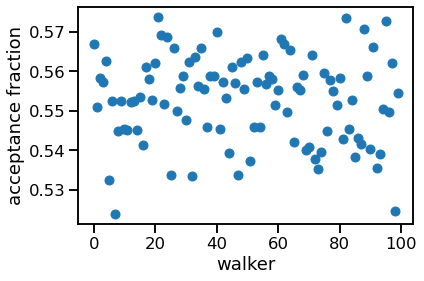

In [272]:
plt.plot(result_emcee.acceptance_fraction, 'o')
plt.xlabel('walker')
plt.ylabel('acceptance fraction')

In [273]:
if hasattr(result_emcee, "acor"):
    print("Autocorrelation time for the parameters:")
    print("----------------------------------------")
    for i, p in enumerate(result_emcee.params):
        try:
            print(f'{p} = {result_emcee.acor[i]:.3f}')
        except IndexError:
            pass

Autocorrelation time for the parameters:
----------------------------------------
r0 = 59.586
sig2 = 59.795
m = 56.574
s0 = 53.065


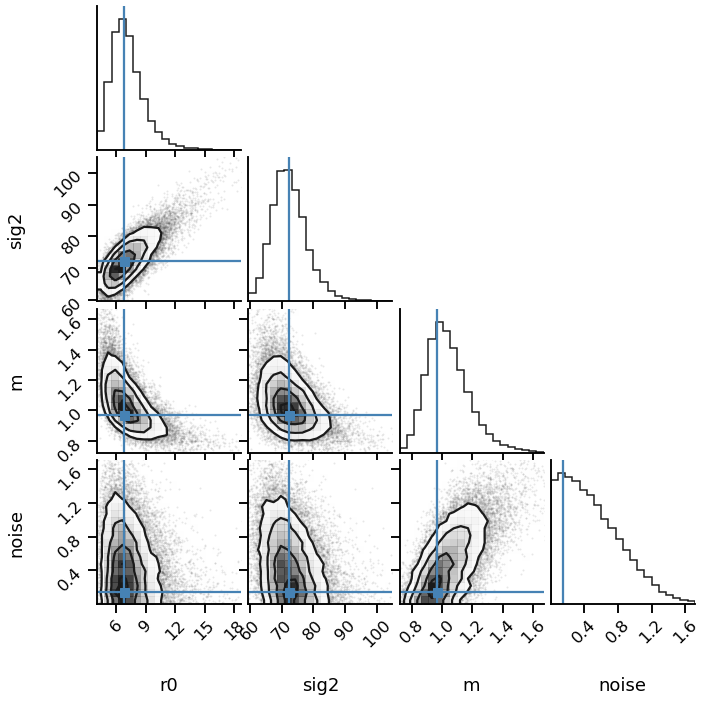

In [282]:
# We need to remove the frozen parameters from the list before passing it as the truths argument
truths = [_.value for _ in emcee_params.values() if _.vary]

emcee_corner = corner.corner(
    result_emcee.flatchain, 
    labels=result_emcee.var_names,
    truths=truths,
    labelpad=0.2,
    range=[0.995]*4,
)
sns.despine()

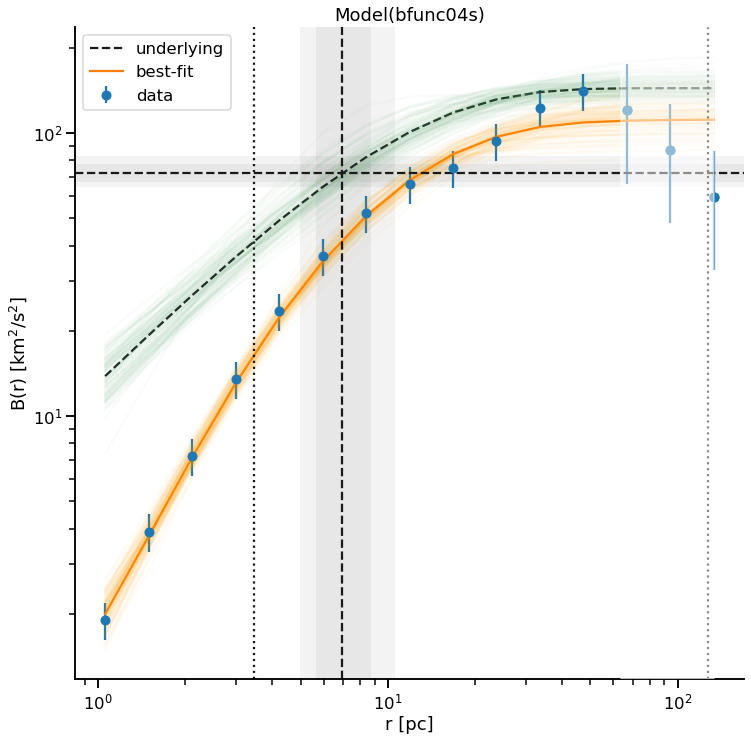

In [277]:
fig, ax = plt.subplots(figsize=(12, 12))

best = result_emcee.params.valuesdict()

# Plot the underlying model without instrumental effects
Bu = bfunc.bfunc00s(r, best["r0"], best["sig2"], best["m"])
ax.plot(r, Bu, color="k", linestyle="dashed", label="underlying")

# Plot the fit results
result_emcee.plot_fit(ax=ax)

# Plot a random sample of the emcee chain
inds = np.random.randint(len(result_emcee.flatchain), size=100)
for ind in inds:
    sample = result_emcee.flatchain.iloc[ind]
    Bsamp = bfunc.bfunc04s(r, sample.r0, sample.sig2, sample.m, best["s0"], sample.noise, box_size)
    ax.plot(r, Bsamp, alpha=0.03, color="orange")
    Busamp = bfunc.bfunc00s(r, sample.r0, sample.sig2, sample.m)
    ax.plot(r, Busamp, alpha=0.03, color="g")

# Add in the points not included in fit
ax.plot(r[large_scale], B[large_scale], "o")

# Dotted lines for 2 x rms seeing and for box size
ax.axvline(2 * best["s0"], color="k", linestyle="dotted")
#spread_span(ax, 2 * result_emcee.flatchain.s0, orient="v")

ax.axvline(best["box_size"], color="k", linestyle="dotted")

# Dashed lines for best-fit r0 and sig2
ax.axvline(best["r0"], color="k", linestyle="dashed")
spread_span(ax, result_emcee.flatchain.r0, orient="v")

ax.axhline(best["sig2"], color="k", linestyle="dashed")
spread_span(ax, result_emcee.flatchain.sig2, orient="h")

# Gray box to indicate the large scale values that are excluded from the fit
ax.axvspan(best["box_size"] / 2, r[-1], color="w", alpha=0.5, zorder=100)

ax.set(
    xscale = "log",
    yscale = "log",
    xlabel = "r [pc]",
    ylabel = r"B(r) [km$^{2}$/s$^{2}$]",
)
sns.despine();

In [279]:
2.35 * best["s0"] / pc_per_arcsec

1.0